## File: gpt_replicating_travelAgent_DAG.ipynb
#### Summary: This file tries to replicate Travel Agents occupation DAG using ChatGPT

#### By: Peyman Shahidi
#### First Created: June 12, 2024

#### Last Edit by Peyman on June 15, 2024

In [1]:
#Python
import os
import getpass
import glob
import numpy as np
import pandas as pd
import random
import networkx as nx
import requests
import re

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

/Users/peymansh/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'
    output_path = f'{main_folder_path}/output/daily_tasks_occupations_analysis'

# Functions

In [3]:
def create_adjacency_matrix(adjacency_matrix_df):
    # keep names for node labels
    task_names = adjacency_matrix_df.columns.tolist()
    task_names = [x.split()[0] for x in task_names]
    node_labels = {value: index for value, index in enumerate(task_names)}
    print(node_labels) 

    # convert adjacency matrix to numpy array for graph depiction
    adjacency_matrix = adjacency_matrix_df.values
    adjacency_matrix = np.nan_to_num(adjacency_matrix, nan=0.0)
    return adjacency_matrix

def GPT_prompter(system_role_msg, prompt, temperature, api_key):
    # send request to GPT
    response = requests.post(
        url = "https://api.openai.com/v1/chat/completions",
        headers = {"Authorization": f"Bearer {api_key}"},
        json ={
            "model": "gpt-4o",
            "temperature": temperature,
            "seed": 265,
            "messages": [{"role": "system", "content": system_role_msg},
                         {"role": "user", "content": prompt}
                        ]
        }
    )
    
    # GPT's answer
    answer = response.json()['choices'][0]['message']['content']
    return answer


def extract_numeric(text):
    pattern = r'{answer:\s*([0-9]+\.?[0-9]*)\s*(?:minutes)?}'
    match = re.search(pattern, text)
    return float(match.group(1)) if match else None

## Graph of Travel Agents

In [4]:
# Read the adjacency matrix
occupation = 'travelAgents'
file_path = f'{data_path}/daily_tasks_occupations_analysis/{occupation}'
adjacency_matrix = pd.read_csv(f'{file_path}/{occupation}_AM.csv', index_col=0)

# keep names for node labels
task_names = adjacency_matrix.columns.tolist()
task_names = [x.split()[0] for x in task_names]
node_labels = {value: index for value, index in enumerate(task_names)}
print(node_labels) 

# convert adjacency matrix to numpy array for graph depiction
adjacency_matrix = adjacency_matrix.values
adjacency_matrix = np.nan_to_num(adjacency_matrix, nan=0.0)

{0: 'Collect', 1: 'Converse', 2: 'Compute', 3: 'Book', 4: 'Plan,', 5: 'Provide', 6: 'Print', 7: 'Record', 8: '"Sink"'}


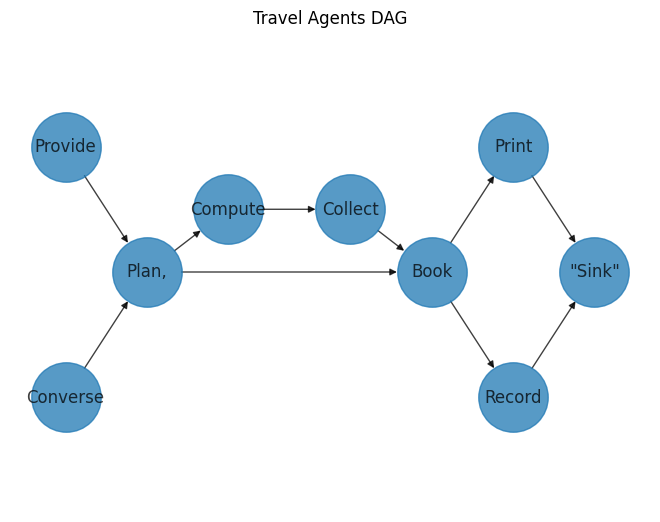

In [5]:
# Create a directed graph from the adjacency matrix
G = nx.DiGraph(adjacency_matrix)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Modify node positions
pos[0] = (0, 0.0025) # Collect
pos[1] = (-1.75, -0.005) # Converse
pos[2] = (-.75, 0.0025) # Compute
pos[3] = (0.5, 0) # Book 
pos[4] = (-1.25, 0) # Plan
pos[5] = (-1.75, 0.005) # Provide
pos[6] = (1, 0.005) # Print
pos[7] = (1, -0.005) # Record
pos[8] = (1.5, 0) # Sink

# Draw the graph with modified positions and labels
nx.draw(G, pos, with_labels=True, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
plt.title("Travel Agents DAG")
plt.savefig(f'{file_path}/{occupation}_DAG.png')

## Replication Test w/ GPT

In [6]:
# List of tasks and occupation
occupation = 'travelAgents'
file_path = f'{data_path}/daily_tasks_occupations_analysis/{occupation}'
df = pd.read_csv(f'{file_path}/{occupation}_AM.csv', index_col=0)

tasks_list = df.columns.tolist()
if '"Sink"' in tasks_list:
    tasks_list.remove('"Sink"')
tasks_list


prompt_occupation = "Travel Agent"


# prompt GPT
prompt = f'I am giving you {len(tasks_list)} tasks for this occupation: {occupation}:\n'
i = 1
for task in tasks_list:
    prompt = prompt + f'Task {i}: {str(task)}'
    i += 1
prompt += f'\n\nFor each task, tell me if completing each of the other tasks are a prerequisite of fulfilling that task.\
The ultimate goal agent is trying to achieve is to help customers find and book desired itineries for their travels.'

prompt += '\n\nNext, create a matrix whose elements are separated by "," such that rows and columns of the matrix are the tasks of above occupation. \
In each column, if the row task is a prerequisite of the column task enter a 1 in that position, otherwrise input 0. For example, \
if Task number 1 is a prerequisite for Task number 2 then the element in the (1,2) position must be 1. Similarly, if \
Task number 1 is not a prerequisite for Task number 3 then the element in the (1,3) position must be 0.'


persona = f'You are answering questions as if you were a human. Do not break character. \
You are an agent with the following persona: an expert travel agent who is at the top of his game.'


ans = GPT_prompter(system_role_msg=persona, 
                       prompt=prompt, 
                       temperature=0, 
                       api_key=api_key)

In [7]:
cleaned_ans = ans.split('\n')
cleaned_ans

["Sure, let's break down the prerequisites for each task first:",
 '',
 '1. **Collect payment for transportation and accommodations from customer.**',
 '   - Prerequisites: Task 2, Task 3, Task 4, Task 5',
 '',
 '2. **Converse with customer to determine destination, mode of transportation, travel dates, financial considerations, and accommodations required.**',
 '   - Prerequisites: None',
 '',
 "3. **Compute cost of travel and accommodations, using calculator, computer, carrier tariff books, and hotel rate books, or quote package tour's costs.**",
 '   - Prerequisites: Task 2',
 '',
 '4. **Book transportation and hotel reservations, using computer or telephone.**',
 '   - Prerequisites: Task 2, Task 3',
 '',
 '5. **Plan, describe, arrange, and sell itinerary tour packages and promotional travel incentives offered by various travel carriers.**',
 '   - Prerequisites: Task 2',
 '',
 '6. **Provide customer with brochures and publications containing travel information, such as local custo

In [13]:
# convert GPT answer to readable format
GPTproposed_matrix_raw = cleaned_ans[-11:-3]

# # convert format to list of strings
# list_of_rows = [re.search(r'\[([^\[\]]+)\]', x).group(1) for x in GPTproposed_matrix]

# # Split each row string by spaces to create rows
# rows = [list(map(int, s.split(' '))) for s in list_of_rows]

# Convert the list of strings to a list of lists of integers
matrix_list = [list(map(int, x.split(','))) for x in GPTproposed_matrix_raw]

# Convert the list of lists to a NumPy array
GPTproposed_matrix = np.array(matrix_list)
GPTproposed_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

## GPT's DAG

Text(0.5, 1.0, 'GPT Travel Agents DAG')

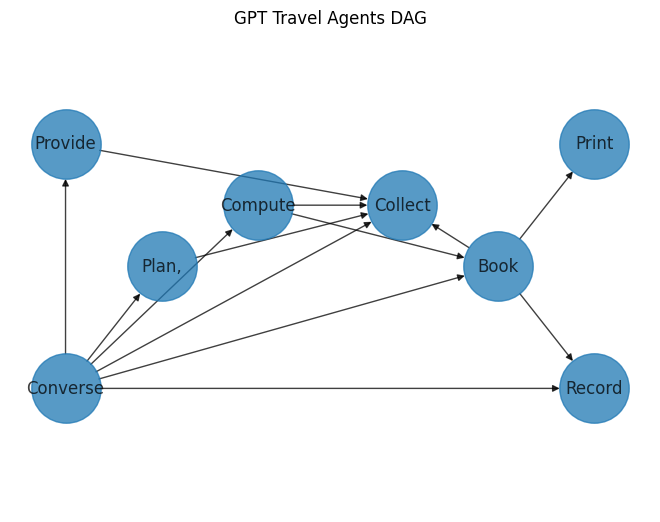

In [14]:
# Create a directed graph from the adjacency matrix
G = nx.DiGraph(GPTproposed_matrix)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Modify node positions
pos[0] = (0, 0.0025) # Collect
pos[1] = (-1.75, -0.005) # Converse
pos[2] = (-.75, 0.0025) # Compute
pos[3] = (0.5, 0) # Book 
pos[4] = (-1.25, 0) # Plan
pos[5] = (-1.75, 0.005) # Provide
pos[6] = (1, 0.005) # Print
pos[7] = (1, -0.005) # Record
pos[8] = (1.5, 0) # Sink

# Draw the graph with modified positions and labels
nx.draw(G, pos, with_labels=True, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
plt.title("GPT Travel Agents DAG")
#plt.savefig(f'{file_path}/{occupation}_DAG_GPT.png')

## Compare GPT against our DAG - Get missing edges present in one but not the other

In [15]:
adjacency_matrix_GPT = GPTproposed_matrix.copy()

# add the sink node
adjacency_matrix_GPT = np.vstack([adjacency_matrix_GPT, np.zeros(adjacency_matrix_GPT.shape[1], dtype=adjacency_matrix_GPT.dtype)])
adjacency_matrix_GPT = np.hstack([adjacency_matrix_GPT, np.zeros((adjacency_matrix_GPT.shape[0], 1), dtype=adjacency_matrix_GPT.dtype)])

In [16]:
# Subtract the GPT matrix from ours
diff_matrix = adjacency_matrix - adjacency_matrix_GPT

# subset edges which are in our DAG but not in GPT's
inOurs_notInGPT = diff_matrix.copy()
inOurs_notInGPT[inOurs_notInGPT < 0] = 0

# subset edges which are in GPT's DAG but not in ours
inGPT_notInOurs = diff_matrix.copy()
inGPT_notInOurs[inGPT_notInOurs > 0] = 0
inGPT_notInOurs[inGPT_notInOurs < 0] = 1

Text(0.5, 1.0, 'Travel Agents Edges Present in Our DAG but not in GPT DAG')

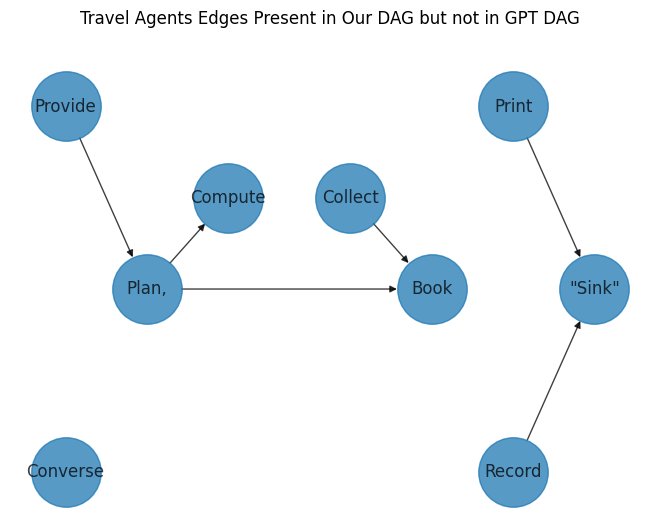

In [17]:
# Create a directed graph from the adjacency matrix
G = nx.DiGraph(inOurs_notInGPT)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Modify node positions
pos[0] = (0, 0.0025) # Collect
pos[1] = (-1.75, -0.005) # Converse
pos[2] = (-.75, 0.0025) # Compute
pos[3] = (0.5, 0) # Book 
pos[4] = (-1.25, 0) # Plan
pos[5] = (-1.75, 0.005) # Provide
pos[6] = (1, 0.005) # Print
pos[7] = (1, -0.005) # Record
pos[8] = (1.5, 0) # Sink

# Draw the graph with modified positions and labels
nx.draw(G, pos, with_labels=True, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
plt.title("Travel Agents Edges Present in Our DAG but not in GPT DAG")
#plt.savefig(f'{file_path}/{occupation}_DAG_GPT.png')

Text(0.5, 1.0, 'Travel Agents Edges Present in GPT DAG but not in our DAG')

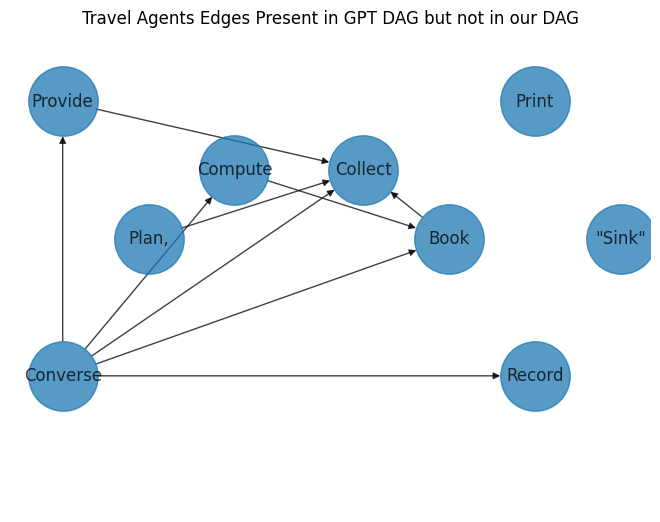

In [18]:
# Create a directed graph from the adjacency matrix
G = nx.DiGraph(inGPT_notInOurs)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using the spring layout algorithm

# Modify node positions
pos[0] = (0, 0.0025) # Collect
pos[1] = (-1.75, -0.005) # Converse
pos[2] = (-.75, 0.0025) # Compute
pos[3] = (0.5, 0) # Book 
pos[4] = (-1.25, 0) # Plan
pos[5] = (-1.75, 0.005) # Provide
pos[6] = (1, 0.005) # Print
pos[7] = (1, -0.005) # Record
pos[8] = (1.5, 0) # Sink

# Draw the graph with modified positions and labels
nx.draw(G, pos, with_labels=True, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
plt.title("Travel Agents Edges Present in GPT DAG but not in our DAG")
#plt.savefig(f'{file_path}/{occupation}_DAG_GPT.png')